<a href="https://colab.research.google.com/github/TTD-JPO/TDD-project/blob/main/Main_TweetDisasterDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Twitter Disaster Detection

<center>

# Load Libs & Data

In [1]:
import pandas as pd
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta, time

In [2]:
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

In [3]:
from sklearn.pipeline import make_pipeline


from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score, plot_confusion_matrix, roc_auc_score, roc_curve

from sklearn.naive_bayes import CategoricalNB, MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [4]:
import re
import string
import nltk

nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from wordcloud import STOPWORDS
from nltk.stem import PorterStemmer

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[Link to data (csv) @google drive](https://drive.google.com/file/d/1QPragNh_wYQVsXQvds8sqjDMfzARD638/view?usp=sharing)


In [5]:
url = 'https://raw.githubusercontent.com/TTD-JPO/TDD-project/main/disaster_tweets.csv'
disaster_tweets = pd.read_csv(url, encoding='latin-1')

# Helper function

In [6]:
pipe_name=[]
auc=[]
fpr=[]
tpr=[]

In [7]:
def clean_text(text):
  '''get rid of all unwanted punctuation and digits'''
  text = text.replace("´", "'")

  digi_punct = "[^a-zA-Z' ]"
  text = re.sub(digi_punct, " ", text)
  text = " ".join(text.split())
  text = text.lower()

  return text

def my_df_text_mining(df, col): 
  ''' stopword and lemmatizer '''
  lemmatizer = WordNetLemmatizer()
  my_stopwords = stopwords.words("english")
  
  df["_no_stopwords"] = df[col].apply(             lambda texxt: " ".join([word for word in clean_text(texxt).split() if word not in my_stopwords]))
  df[col]             = df["_no_stopwords"].apply( lambda texxt: " ".join([lemmatizer.lemmatize(word) for word in texxt.split()]) )

  return df.drop(["_no_stopwords"], axis=1)


def my_df_text_mining2(df, col): 
  ''' stopword and stemming '''
  stemmer = PorterStemmer()
  my_stopwords = stopwords.words("english")
  
  df["_no_stopwords"] = df[col].apply(             lambda texxt: " ".join([word for word in clean_text(texxt).split() if word not in my_stopwords]))
  df[col]             = df["_no_stopwords"].apply( lambda texxt: " ".join([stemmer.stem(word) for word in texxt.split()]) )

  return df.drop(["_no_stopwords"], axis=1)
 ############################################# 

def my_df_spacy_locgpe(df, col):  
  df["loc_gpe"] = df[col].apply( lambda texxt: " ".join([ ent.text for ent in nlp( clean_text(texxt) ).ents  if ((ent.label_ =='LOC') | (ent.label_ =='GPE'))]) )
  return df

def my_df_spacy_date_time(df, col):
  df["date_time"] = df[col].apply( lambda texxt: " ".join([ ent.text for ent in nlp( clean_text(texxt) ).ents  if ((ent.label_ =='DATE') | (ent.label_ =='TIME'))]) )
  return df

def my_df_spacy_fac(df, col):
  df["FAC"] = df[col].apply( lambda texxt: " ".join([ ent.text for ent in nlp( clean_text(texxt) ).ents  if (ent.label_ =='FAC') ]) )
  return df
################################

def spcy_test(text):
  displacy.render(nlp(clean_text(text)), style='ent', jupyter=True)


In [8]:
def corpus_func(series):
    '''create a text block (corpus) from a series'''
    return " ; ".join(text for text in series)

In [9]:
def plot_roc_auc(pipe_name_list, fpr_list, tpr_list, auc_list):
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title(f"ROC curve with test-AUC")

  for pn, fpr, tpr, auc in zip(pipe_name_list, fpr_list, tpr_list, auc_list):
    plt.plot(fpr, tpr, label=pn+" auc:"+str(f"{auc:0.3f}"))
  
  plt.legend(fontsize=10) # using a size in points
  plt.legend(loc='best')
  plt.show()

In [10]:
def my_fit_cm(df, pipe, feature_list, target):
  '''includes 
     - train test split, 
     - model fit,
     - plots confusion matrix and
     - ROC curves'''
  

  X_train, X_test,\
  y_train, y_test =\
  train_test_split(df[feature_list],
                    df[target],
                    test_size=0.2,
                    random_state=314159,
                    stratify=df[target])

  #display( cross_val_score(pipe, X_train, y_train).mean() )

  pipe.fit(X_train, y_train)
  plot_confusion_matrix(pipe, X_train, y_train, values_format="0.3f", normalize='true', cmap=plt.cm.Blues)#, cmap="RdYlGn")
  plt.title(f"best accuracy: { accuracy_score(y_train, pipe.predict(X_train)):0.3f}, train")
  
  plot_confusion_matrix(pipe, X_test, y_test, values_format="0.3f", normalize='true', cmap=plt.cm.Blues)#, cmap="RdYlGn")
  plt.title(f"best accuracy: { accuracy_score(y_test, pipe.predict(X_test)):0.3f}, test")
  plt.show()

  # ROC curve with AUC ##
  plt.plot([0, 1], [0, 1], 'k--')
  fpr, tpr, thresholds = roc_curve(y_train, pipe.predict_proba(X_train)[:, 1] )
  plt.plot(fpr, tpr, label='train', c="black")

  fpr_, tpr_, thresholds_ = roc_curve(y_test, pipe.predict_proba(X_test)[:, 1] )
  plt.plot(fpr_, tpr_, label='test', c="red")

  # show real values in plot as text
  offset_x,offset_y = -0.25 , 0.025
  fpr__, tpr__, thresholds_ = roc_curve(y_test, pipe.predict(X_test) )
  if (fpr__[1] < -offset_x) :   offset_x, offset_y = offset_y, -offset_y
  plt.text(fpr__[1]+offset_x, tpr__[1]+offset_y, f"({fpr__[1]:0.3f}, {tpr__[1]:0.3f})", c="r")
  plt.scatter(fpr__[1], tpr__[1], c="red")
    

  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  test_auc_score = roc_auc_score(y_test, pipe.predict(X_test))
  plt.title(f"ROC curve with test-AUC:{test_auc_score:0.3f}")
  plt.legend(loc='best')
  plt.show()
  # for further plotting .
  return fpr_, tpr_ , test_auc_score
 

In [11]:
def plot_words_to_target (df, wordlist, target):
    '''group word lists according to target values and form mean value
       plot wordlist ans target, sorted by wordlist '''
    df['target_mean'] = df.groupby(wordlist)[target].transform('mean')

    fig = plt.figure(figsize=(8, 72), dpi=100)

    sns.countplot(y=df.sort_values(by='target_mean', ascending=False)[wordlist],
                hue=df.sort_values(by='target_mean', ascending=False)[target])

    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=12)
    plt.legend(loc=1)
    plt.title(f'Target Distribution in {wordlist}')

## Evaluate data

In [12]:
disaster_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [13]:
print( "absolute number of disaster indicated messages:", disaster_tweets.target.sum() )
print( f"relative number of disaster indicated messages: {disaster_tweets.target.sum() / disaster_tweets.shape[0] :0.3f}" )

absolute number of disaster indicated messages: 3271
relative number of disaster indicated messages: 0.430


In [14]:
keys      = list(disaster_tweets.keyword.unique() )
locations = list(disaster_tweets.location.unique() )
print(f'len_keys: {len(keys)}\tlen_locations: {len(locations)}')

len_keys: 222	len_locations: 3342


In [15]:
disaster_tweets.groupby('keyword').target.count().sort_values(ascending=False)

keyword
fatalities               45
deluge                   42
armageddon               42
body%20bags              41
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: target, Length: 221, dtype: int64

In [16]:
disaster_tweets.groupby('location').target.count().sort_values(ascending=False)

location
USA                            104
New York                        71
United States                   50
London                          45
Canada                          29
                              ... 
Republica Dominicana             1
Republic of the Philippines      1
Regalo Island                    1
Redondo Beach, CA                1
                                 1
Name: target, Length: 3341, dtype: int64

In [17]:
display( f"relative number of keyword   messages: {disaster_tweets.keyword.nunique()  / disaster_tweets.shape[0] :0.3f}" )
display( f"relative number of location  messages: {disaster_tweets.location.nunique() / disaster_tweets.shape[0] :0.3f}" )

'relative number of keyword   messages: 0.029'

'relative number of location  messages: 0.439'

## Visualization of data (of)

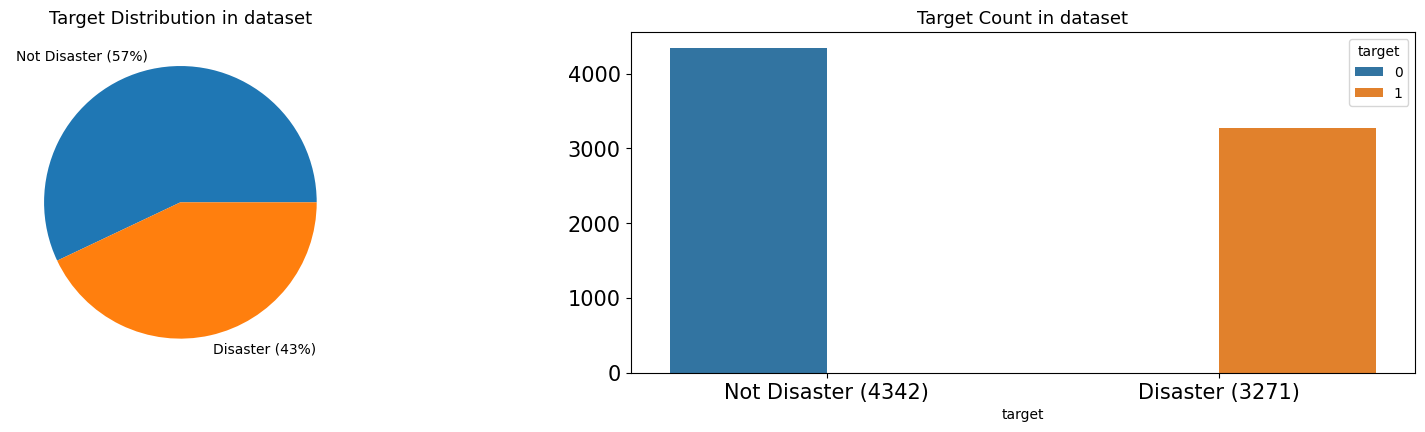

In [18]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

disaster_tweets.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'])
sns.countplot(x=disaster_tweets['target'], hue=disaster_tweets['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in dataset', fontsize=13)
axes[1].set_title('Target Count in dataset', fontsize=13)

plt.show()

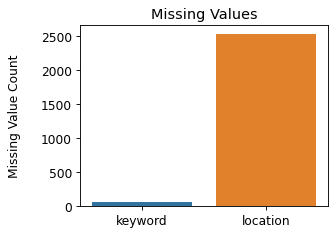

In [19]:
missing_cols = ['keyword', 'location']

plt.figure(figsize=(4, 3), dpi=80)

sns.barplot(x=disaster_tweets[missing_cols].isna().sum().index, y=disaster_tweets[missing_cols].isna().sum().values)

plt.ylabel('Missing Value Count', size=11, labelpad=18)
plt.tick_params(axis='x', labelsize=11)
plt.tick_params(axis='y', labelsize=11)

plt.title('Missing Values', fontsize=13)

plt.show()

# Cleaning of data 
- df deaster tweets - 'dtt_clean'

In [20]:
dtt_clean = disaster_tweets.copy()

### clean NaN

In [21]:
missing_cols = ['keyword', 'location']
for col in  missing_cols:
    dtt_clean[col] = dtt_clean[col].fillna(f'no_{col}')

In [22]:
dtt_clean.head(2)

,id,keyword,location,text,target
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1


# Analizing tweet < text >
- NLP text 
- NLP keyword, localization 

In [23]:
#clean text
dtt_clean = my_df_text_mining(dtt_clean, 'text')

In [24]:
dtt_clean.head(3)

,id,keyword,location,text,target
0,1,no_keyword,no_location,deed reason earthquake may allah forgive u,1
1,4,no_keyword,no_location,forest fire near la ronge sask canada,1
2,5,no_keyword,no_location,resident asked 'shelter place' notified office...,1


# Visualisation clean text

In [25]:
dtt_clean['text']

0              deed reason earthquake may allah forgive u
1                   forest fire near la ronge sask canada
2       resident asked 'shelter place' notified office...
3       people receive wildfire evacuation order calif...
4       got sent photo ruby alaska smoke wildfire pour...
                              ...                        
7608    two giant crane holding bridge collapse nearby...
7609    aria ahrary thetawniest control wild fire cali...
7610             utc km volcano hawaii http co zdtoyd ebj
7611    police investigating e bike collided car littl...
7612    latest home razed northern california wildfire...
Name: text, Length: 7613, dtype: object

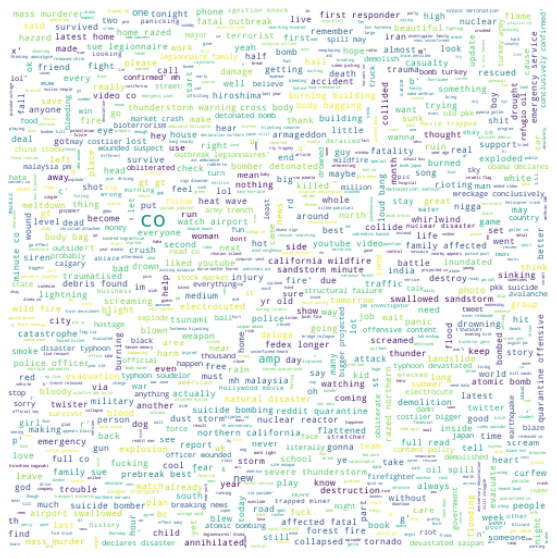

In [26]:
from collections import Counter

genres=list(dtt_clean['text'])
gen=[]

for i in genres:
    i=list(i.split(','))
    for j in i:
        gen.append(j.replace(' '," "))
g=Counter(gen)

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

text = list(set(gen))
#plt.rcParams['figure.figsize'] = (20, 20)
wordcloud = WordCloud(max_font_size=20, max_words=1000,background_color="white", width=500, height=500).generate(str(text))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

In [27]:
#Regex:
clean_cols = ['keyword','location']
for col in clean_cols: 
    dtt_clean[f'{col}_re'] = dtt_clean[col].apply(lambda text: re.sub("%20"," ", text))

In [28]:
keyword_low   = [x.lower() for x in dtt_clean['keyword_re']]
location_low  = [x.lower() for x in dtt_clean['location_re']]

In [29]:
# analog to goupby in Evaluate data (but after clean keyword)
# make a count for the keyword list

key_count = sorted(Counter(list(dtt_clean['keyword_re'])).items(), key = lambda kv:( kv[1], kv[0]), reverse=True)
loc_count = sorted(Counter(list(dtt_clean['location_re'])).items(), key = lambda kv:( kv[1], kv[0]), reverse=True)
print(f'{key_count[0:20]}\n{loc_count[0:20]}')

[('no_keyword', 61), ('fatalities', 45), ('deluge', 42), ('armageddon', 42), ('sinking', 41), ('harm', 41), ('damage', 41), ('body bags', 41), ('windstorm', 40), ('twister', 40), ('siren', 40), ('outbreak', 40), ('fear', 40), ('evacuate', 40), ('collided', 40), ('wrecked', 39), ('wreckage', 39), ('whirlwind', 39), ('weapons', 39), ('weapon', 39)]
[('no_location', 2533), ('USA', 104), ('New York', 71), ('United States', 50), ('London', 45), ('Canada', 29), ('Nigeria', 28), ('UK', 27), ('Los Angeles, CA', 26), ('India', 24), ('Mumbai', 22), ('Washington, DC', 21), ('Kenya', 20), ('Worldwide', 19), ('Chicago, IL', 18), ('Australia', 18), ('California', 17), ('New York, NY', 15), ('Everywhere', 15), ('California, USA', 15)]


In [30]:
stemmer = PorterStemmer()

newColumn = []
for w in keyword_low: 
    newColumn.append(stemmer.stem(w))

dtt_clean['keyword_clean'] = newColumn

In [31]:
key_stem_count = sorted(Counter(list(dtt_clean['keyword_clean'])).items(), key = lambda kv:( kv[1], kv[0]), reverse=True)
print(key_stem_count[0:20])

[('fatal', 120), ('evacu', 112), ('derail', 112), ('flood', 109), ('body bag', 107), ('scream', 105), ('drown', 104), ('bomb', 101), ('hijack', 100), ('suicide bomb', 99), ('obliter', 91), ('weapon', 78), ('wreck', 76), ('death', 74), ('collid', 74), ('blaze', 72), ('quarantin', 71), ('injuri', 71), ('explod', 71), ('attack', 71)]


In [32]:
l_stopwords = stopwords.words("english")

location_oStop = []
for w in location_low:  
    if w not in l_stopwords: 
        location_oStop.append(w)
    else:
        location_oStop.append(' ')

print(location_oStop[:20])

['no_location', 'no_location', 'no_location', 'no_location', 'no_location', 'no_location', 'no_location', 'no_location', 'no_location', 'no_location', 'no_location', 'no_location', 'no_location', 'no_location', 'no_location', 'no_location', 'no_location', 'no_location', 'no_location', 'no_location']


In [33]:
dtt_clean['location_oStop'] = location_oStop

In [34]:
digi_punct = "[^a-zA-Z/,']"
dtt_clean['location_clean'] = dtt_clean['location_oStop'].apply(lambda text: re.sub("digi_punct"," ", text))

In [35]:
print(f"key_unique, org:     {len(keys)}\t locations: {len(locations)}")
print(f"key_unique, regex:   {len(dtt_clean['keyword_re'].unique())}\t locations: {len(dtt_clean['location_re'].unique())}")
print(f"key_unique, stemmed: {len(dtt_clean['keyword_clean'].unique())}\t locations: {len(dtt_clean['location_clean'].unique())}")

key_unique, org:     222	 locations: 3342
key_unique, regex:   222	 locations: 3342
key_unique, stemmed: 167	 locations: 3232


In [36]:
dtt_clean.head(3)

,id,keyword,location,text,target,keyword_re,location_re,keyword_clean,location_oStop,location_clean
0,1,no_keyword,no_location,deed reason earthquake may allah forgive u,1,no_keyword,no_location,no_keyword,no_location,no_location
1,4,no_keyword,no_location,forest fire near la ronge sask canada,1,no_keyword,no_location,no_keyword,no_location,no_location
2,5,no_keyword,no_location,resident asked 'shelter place' notified office...,1,no_keyword,no_location,no_keyword,no_location,no_location


## Keywords

In [37]:
df_keys = dtt_clean.copy()

Distribution of the key words to disaster (= 1) and false message (= 0)

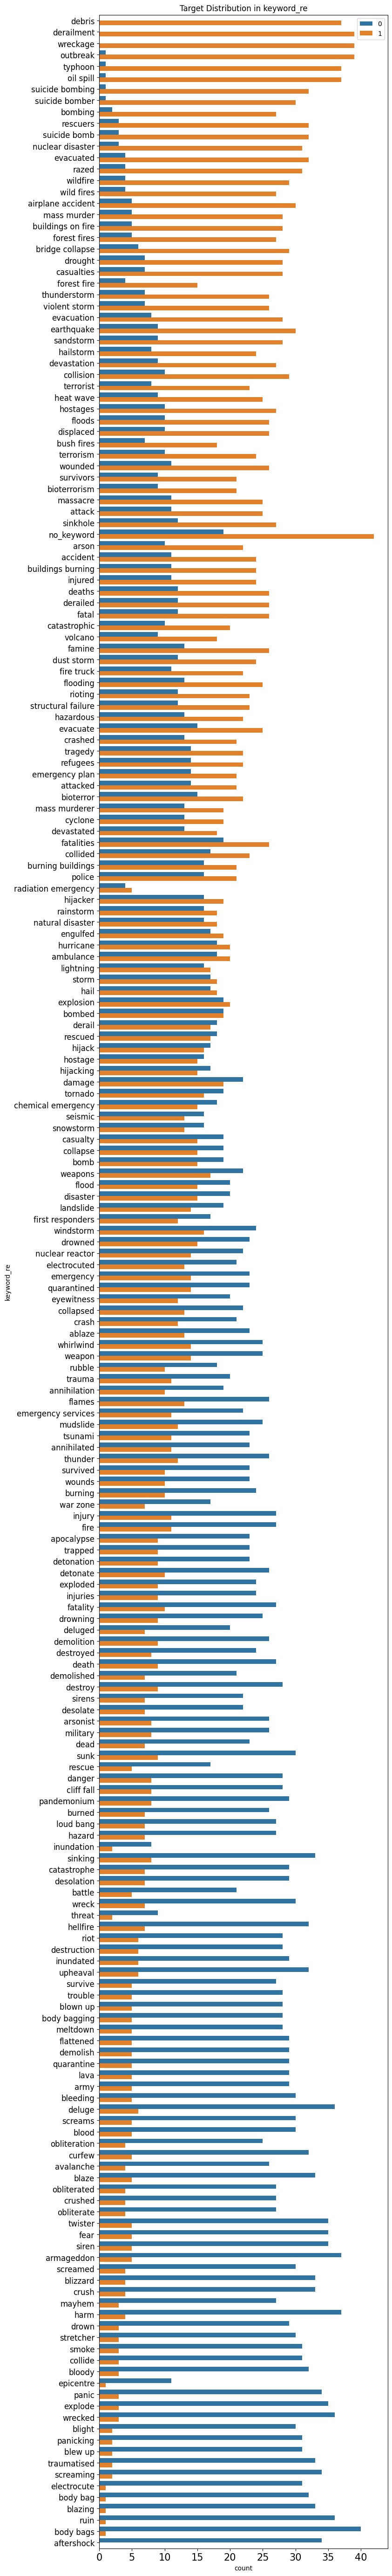

In [38]:
# keywords with regex
plot_words_to_target (df_keys, 'keyword_re', 'target')

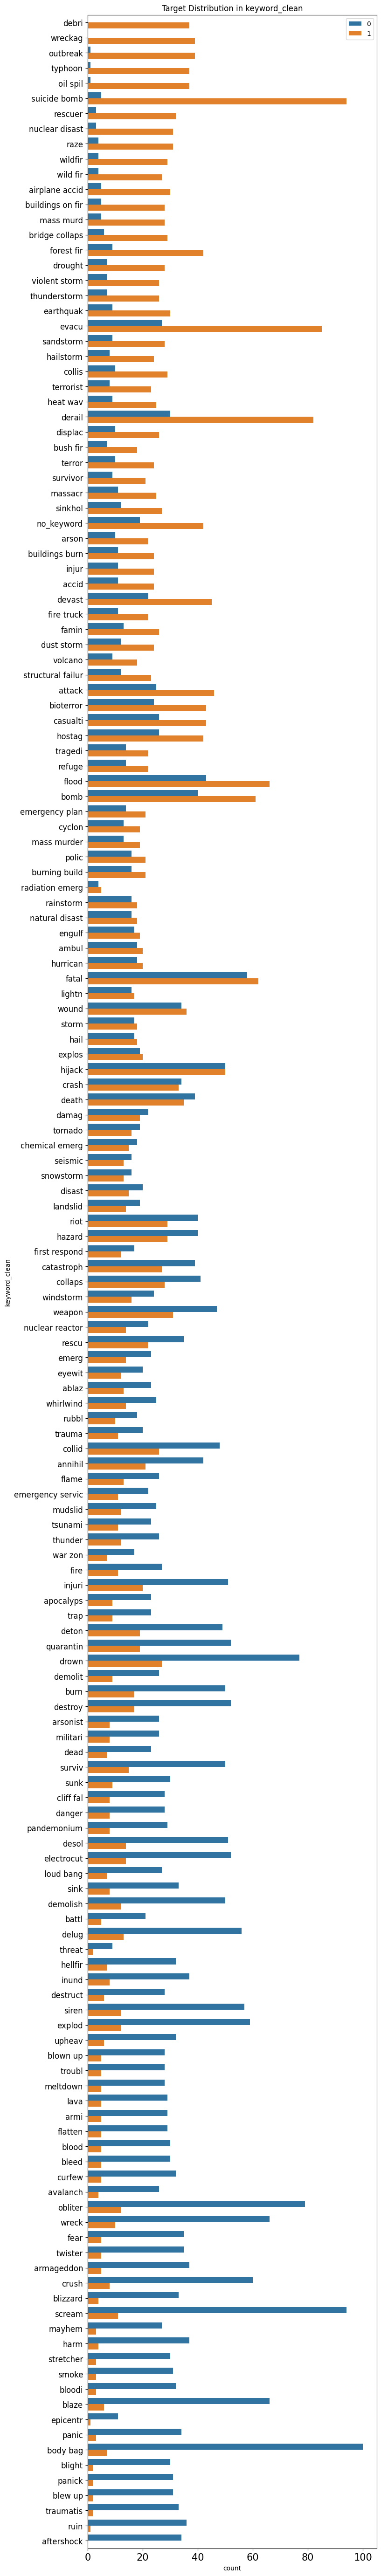

In [39]:
# keywords with regex and porterstemmer
plot_words_to_target (df_keys, 'keyword_clean', 'target')

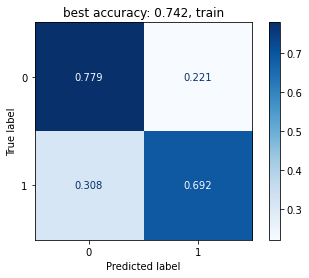

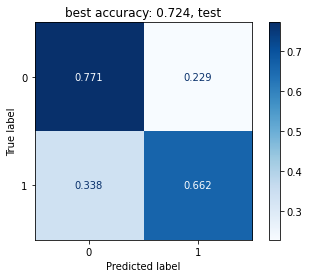

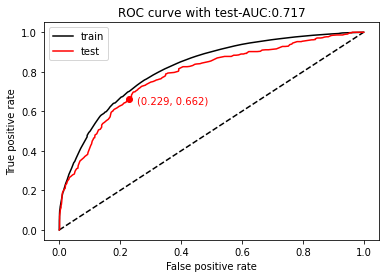

CPU times: user 737 ms, sys: 18 ms, total: 755 ms
Wall time: 777 ms


In [40]:
# Tfidf + MultinominalNB, keywords with regex , df_keys

pipeMNB = make_pipeline(TfidfVectorizer(ngram_range=(1, 1)), MultinomialNB()) 
%time fpr_0, tpr_0, auc_0 = my_fit_cm(df_keys, pipeMNB, "keyword_re", "target")
pipe_name.append( 'keywords_re >> TFIDF(1,1), MNB' )
auc.append( auc_0 )
fpr.append( fpr_0 )
tpr.append( tpr_0 )

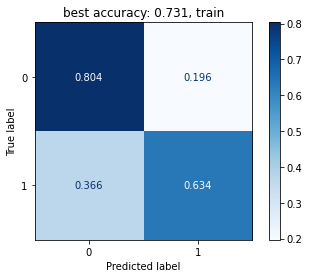

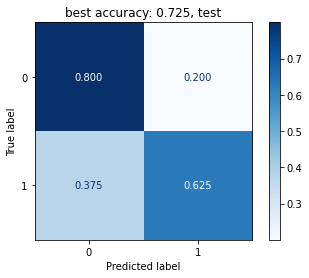

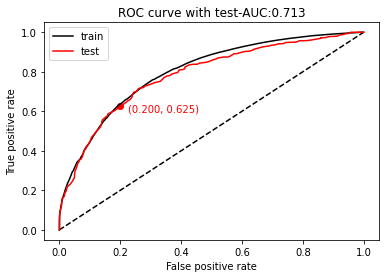

CPU times: user 689 ms, sys: 12.8 ms, total: 702 ms
Wall time: 710 ms


In [41]:
# Tfidf + MultinominalNB, keywords with regex, clean , df_keys

pipeMNB = make_pipeline(TfidfVectorizer(ngram_range=(1, 1)), MultinomialNB()) 
%time fpr_0, tpr_0, auc_0 = my_fit_cm(df_keys, pipeMNB, "keyword_clean", "target")
pipe_name.append( 'keywords_clean >> TFIDF(1,1), MNB' )
auc.append( auc_0 )
fpr.append( fpr_0 )
tpr.append( tpr_0 )

# Try: keyword cleaned, count and % weight to target

In [42]:
no_target_ = df_keys[ df_keys.target == 0]
target_    = df_keys[ df_keys.target == 1]

In [43]:
key_t1a = sorted(Counter(list(target_['keyword_re'])).items(), key = lambda kv:( kv[1], kv[0]), reverse=True)
key_t1b = sorted(Counter(list(target_['keyword_clean'])).items(), key = lambda kv:( kv[1], kv[0]), reverse=True)

key_t0a = sorted(Counter(list(no_target_['keyword_re'])).items(), key = lambda kv:( kv[1], kv[0]), reverse=True)
key_t0a = sorted(Counter(list(no_target_['keyword_clean'])).items(), key = lambda kv:( kv[1], kv[0]), reverse=True)

In [44]:
key_t1x = target_.groupby(['keyword_re'])['target'].count().sort_values(ascending=False)
key_t1x

keyword_re
no_keyword     42
wreckage       39
outbreak       39
derailment     39
typhoon        37
               ..
body bags       1
epicentre       1
body bag        1
ruin            1
electrocute     1
Name: target, Length: 221, dtype: int64

In [45]:
key_t0a = no_target_.groupby(['keyword_re'])['target'].count().sort_values(ascending=False)

##Wordnet - synsets

In [46]:
syn = wordnet.synsets('fire')
syn

[Synset('fire.n.01'),
 Synset('fire.n.02'),
 Synset('fire.n.03'),
 Synset('fire.n.04'),
 Synset('fire.n.05'),
 Synset('ardor.n.03'),
 Synset('fire.n.07'),
 Synset('fire.n.08'),
 Synset('fire.n.09'),
 Synset('open_fire.v.01'),
 Synset('fire.v.02'),
 Synset('fire.v.03'),
 Synset('displace.v.03'),
 Synset('fire.v.05'),
 Synset('fire.v.06'),
 Synset('arouse.v.01'),
 Synset('burn.v.01'),
 Synset('fuel.v.02')]

In [47]:
# first index
print(f'Word and Type :  {syn[0].name()}')
print(f'Synonym of fire is:  {syn[0].lemmas()[0].name()}')
print(f'The meaning of the fire:  {syn[0].definition()}')
print(f'Example of fire : {str(syn[0].examples())}')

Word and Type :  fire.n.01
Synonym of fire is:  fire
The meaning of the fire:  the event of something burning (often destructive)
Example of fire : ['they lost everything in the fire']


In [48]:
# a other index
print(f'Word and Type :  {syn[7].name()}')
print(f'Synonym of fire is:  {syn[7].lemmas()[0].name()}')
print(f'The meaning of the fire:  {syn[7].definition()}')
print(f'Example of fire : {str(syn[7].examples())}')

Word and Type :  fire.n.08
Synonym of fire is:  fire
The meaning of the fire:  a severe trial
Example of fire : ['he went through fire and damnation']


In [49]:
#Creating a list 
synonyms = []
for syn in wordnet.synsets("fire"):
    for lm in syn.lemmas():
             synonyms.append(lm.name()) #adding into synonyms
print (set(synonyms))

{'fervour', 'force_out', 'send_away', 'fervor', 'evoke', 'kindle', 'go_off', 'enkindle', 'burn_down', 'give_the_sack', 'dismiss', 'terminate', 'ardor', 'fervency', 'fuel', 'elicit', 'fire', 'flame', 'attack', 'blast', 'can', 'flak', 'give_the_axe', 'sack', 'flaming', 'ardour', 'discharge', 'provoke', 'arouse', 'fervidness', 'open_fire', 'displace', 'give_notice', 'raise', 'flack', 'burn', 'firing'}


## Location

In [50]:
location_count = sorted(Counter(list(dtt_clean['location'])).items(), key = lambda kv:( kv[1], kv[0]), reverse=True)
location_count[0:20]

[('no_location', 2533),
 ('USA', 104),
 ('New York', 71),
 ('United States', 50),
 ('London', 45),
 ('Canada', 29),
 ('Nigeria', 28),
 ('UK', 27),
 ('Los Angeles, CA', 26),
 ('India', 24),
 ('Mumbai', 22),
 ('Washington, DC', 21),
 ('Kenya', 20),
 ('Worldwide', 19),
 ('Chicago, IL', 18),
 ('Australia', 18),
 ('California', 17),
 ('New York, NY', 15),
 ('Everywhere', 15),
 ('California, USA', 15)]

In [51]:
#df 
df_loc = dtt_clean.copy()

#split df: location, no_location
df_no_location  = df_loc [ df_loc.location == 'no_location']
df_location     = df_loc [ df_loc.location != 'no_location']

In [52]:
# location_count only no_location
location_count_1 = sorted(Counter(list(df_location['location_clean'])).items(), key = lambda kv:( kv[1], kv[0]), reverse=True)
location20_count = location_count_1[0:20]

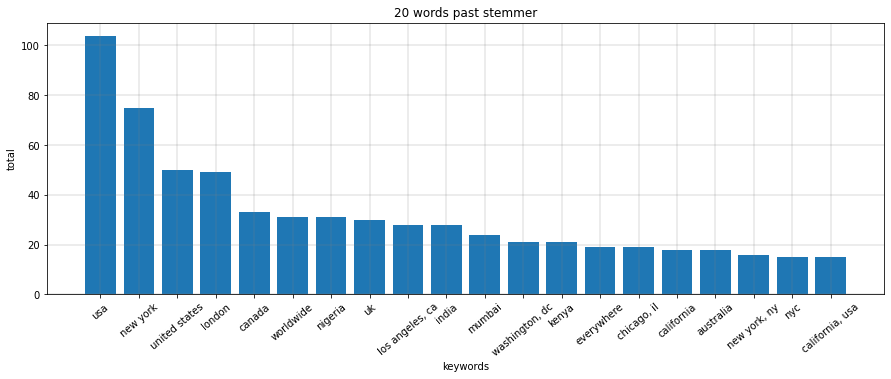

In [53]:
x,y = zip(*location_count_1[0:20]) 

plt.figure(figsize=[15,5])
plt.grid(color='grey', linestyle='-', linewidth=0.3)
plt.bar(x, y)

plt.title('20 words past stemmer')
plt.ylabel('total')
plt.xlabel('keywords' )
plt.xticks(rotation=40)
plt.show()

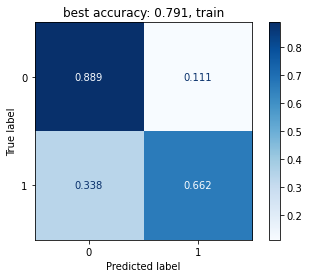

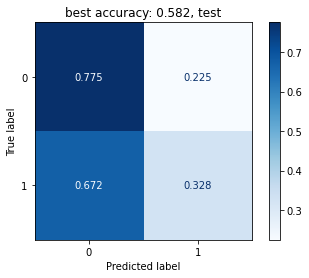

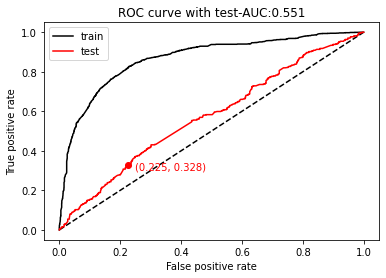

CPU times: user 691 ms, sys: 18 ms, total: 709 ms
Wall time: 739 ms


In [54]:
# Tfidf + MultinominalNB, only location_re, df_location

pipeMNB = make_pipeline(TfidfVectorizer(ngram_range=(1, 1)), MultinomialNB(), ) 
%time fpr_0, tpr_0, auc_0 = my_fit_cm(df_location, pipeMNB, "location_re", "target")
pipe_name.append( 'location_re >> TFIDF(1,1), MNB' )
auc.append( auc_0 )
fpr.append( fpr_0 )
tpr.append( tpr_0 )

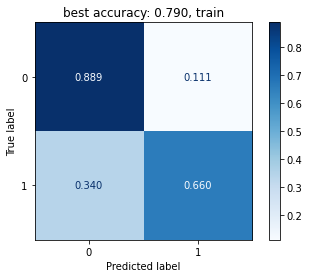

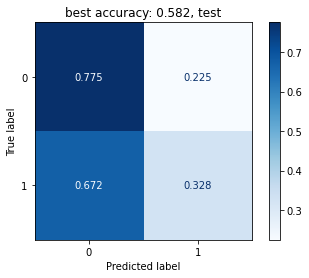

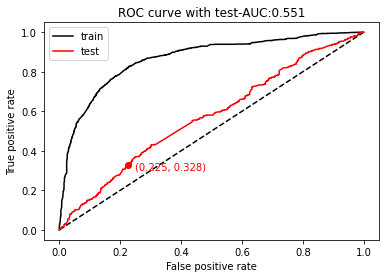

CPU times: user 688 ms, sys: 19 ms, total: 707 ms
Wall time: 718 ms


In [55]:
# Tfidf + MultinominalNB, only Location, df_location

pipeMNB = make_pipeline(TfidfVectorizer(ngram_range=(1, 1)), MultinomialNB()) 
%time fpr_0, tpr_0, auc_0 = my_fit_cm(df_location, pipeMNB, "location_clean", "target")
pipe_name.append( 'location_clean >> TFIDF(1,1), MNB' )
auc.append( auc_0 )
fpr.append( fpr_0 )
tpr.append( tpr_0 )

## location with spacy

In [56]:
location_text = corpus_func(df_location['location_clean'])
location_text[:200]

'birmingham ; est. september 2012 - bristol ; africa ; philadelphia, pa ; london, uk ; pretoria ; world wide!! ; paranaque city ; live on webcam ; milky way ; greensboro,north carolina ; live on webcam'

In [57]:
# find clearly location:
displacy.render(nlp(location_text[:200]), style='ent', jupyter=True)

In [58]:
# find location in text (with displacy.render, style: ent)
%time spcy_test(location_text[:200])

CPU times: user 21.5 ms, sys: 896 µs, total: 22.4 ms
Wall time: 22.7 ms


In [59]:
# Convert the machine learning text document into a spacy document.
# This automatically does POS tagging for you!

nlp = spacy.load('en_core_web_sm')
doc = nlp(location_text)
print(f' doc_type: {type(doc)}\n doc_len: {len(doc)}')

# Count the frequencies of a given attribute.
# A dictionary mapping attributes to integer counts.
from spacy.attrs import ORTH

location_doc_count = doc.count_by(ORTH)
print(f' len_dict: {len(location_doc_count)}')
% time 

 doc_type: <class 'spacy.tokens.doc.Doc'>
 doc_len: 19714
 len_dict: 3329
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


In [60]:
location_doc_countL= [(val,key) for key,val in location_doc_count.items()]
location_doc_countL.sort()
location_doc_countL.reverse()
print(location_doc_countL[:100])

[(5082, 631425121691394544), (1923, 2593208677638477497), (611, 8205403955989537350), (360, 8532415787641010193), (259, 352746334657453960), (213, 12646065887601541794), (212, 4753564829687343602), (177, 7425985699627899538), (150, 13913074996085095135), (147, 2466615745961202537), (139, 2781019763248568108), (132, 9153284864653046197), (117, 686896126224900680), (96, 11605077656157480328), (95, 16933990426988047072), (90, 3002984154512732771), (85, 12559535587248741022), (83, 16765660216731109175), (82, 14667099791903937066), (80, 13377313892767189802), (78, 886050111519832510), (74, 13240663448937832298), (71, 7433872258273860244), (70, 14841823269549666764), (64, 16797228410235430689), (64, 3554169177543738620), (63, 13702981561865844133), (60, 1039183959127729026), (59, 7307884290799599686), (57, 18272869425732394910), (57, 6230481461872698862), (55, 8663801465970268676), (54, 17316305784784916682), (54, 4028385504774843091), (52, 17494803046312582752), (50, 9504827836828505330), (

In [61]:
# Visualize the POS tags of the first sentence in the original text file.
#sentence
sents = list(doc.sents)
print(len(sents))
sents[3]

print(sents[3])

from spacy import displacy 
displacy.render(sents[3],style="dep" ,jupyter=True, options = {'distance' : 100})

534
oh ; new hanover county, nc ; maldives ; manchester, nh ; wilmington, nc ; new hanover county, nc ; global ; alberta | sask.


In [62]:
displacy.render(sents[3],style="ent" ,jupyter=True, options = {'distance' : 100})

# new features

+ word_count number of words in text
+ unique_word_count number of unique words in text
+ stop_word_count number of stop words in text
+ url_count number of urls in text
+ mean_word_length average character count in words
+ char_count number of characters in text
+ punctuation_count number of punctuations in text
+ hashtag_count number of hashtags (#) in text
+ mention_count number of mentions (@) in text

In [63]:
#dataframe new featurers
df_nf = dtt_clean.copy()

In [64]:
# word_count
df_nf['word_count'] = df_nf['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df_nf['unique_word_count'] = df_nf['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df_nf['stop_word_count'] = df_nf['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
df_nf['url_count'] = df_nf['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
df_nf['mean_word_length'] = df_nf['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df_nf['char_count'] = df_nf['text'].apply(len)

# punctuation_count
df_nf['punctuation_count'] = df_nf['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
df_nf['hashtag_count'] = df_nf['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
df_nf['mention_count'] = df_nf['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

In [65]:
df_nf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 7613 non-null   int64  
 1   keyword            7613 non-null   object 
 2   location           7613 non-null   object 
 3   text               7613 non-null   object 
 4   target             7613 non-null   int64  
 5   keyword_re         7613 non-null   object 
 6   location_re        7613 non-null   object 
 7   keyword_clean      7613 non-null   object 
 8   location_oStop     7613 non-null   object 
 9   location_clean     7613 non-null   object 
 10  word_count         7613 non-null   int64  
 11  unique_word_count  7613 non-null   int64  
 12  stop_word_count    7613 non-null   int64  
 13  url_count          7613 non-null   int64  
 14  mean_word_length   7613 non-null   float64
 15  char_count         7613 non-null   int64  
 16  punctuation_count  7613 

In [66]:
num_cols = list(df_nf.select_dtypes(exclude=object).columns)
num_cols

['id',
 'target',
 'word_count',
 'unique_word_count',
 'stop_word_count',
 'url_count',
 'mean_word_length',
 'char_count',
 'punctuation_count',
 'hashtag_count',
 'mention_count']

In [67]:
num_cols[3:]

['unique_word_count',
 'stop_word_count',
 'url_count',
 'mean_word_length',
 'char_count',
 'punctuation_count',
 'hashtag_count',
 'mention_count']

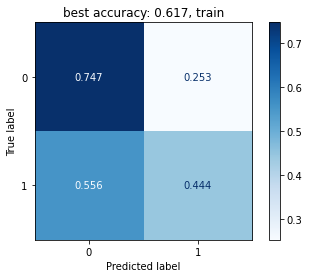

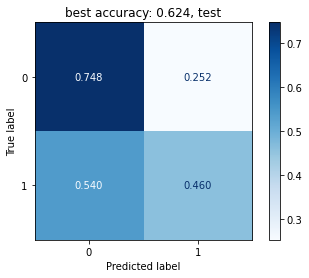

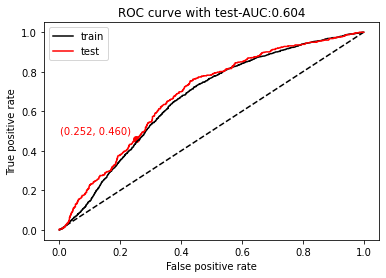

CPU times: user 851 ms, sys: 379 ms, total: 1.23 s
Wall time: 816 ms


In [68]:
#numeric featurelist from text 
feature_list = num_cols[3:]

# go into pipe with Model: LogisticRegression
pipe = make_pipeline( LogisticRegression() ) 
%time fpr__, tpr__, auc__ = my_fit_cm(df_nf, pipe, feature_list, "target")
pipe_name.append( 'num_feature_count, LogReg' )
auc.append( auc__ )
fpr.append( fpr__ )
tpr.append( tpr__ )

# Evaluationg Basic modeling

## Train-Test-Split

##pipline Tfidf, MultinomialNB

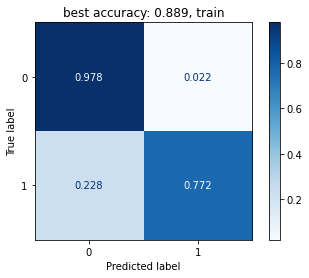

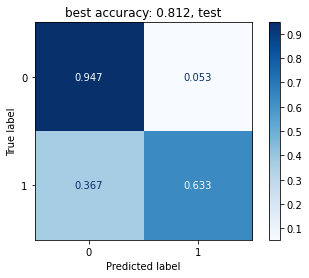

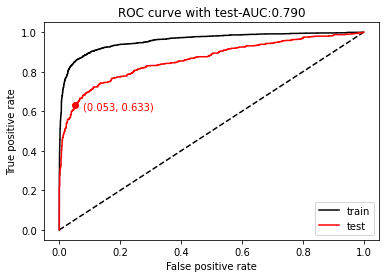

CPU times: user 1.26 s, sys: 12.5 ms, total: 1.27 s
Wall time: 1.31 s


In [69]:
# original data set, no postprocessin
df = disaster_tweets.copy() 
pipeMNB = make_pipeline(TfidfVectorizer(ngram_range=(1, 1)), MultinomialNB()) #### naive bayes 
%time fpr_0, tpr_0, auc_0 = my_fit_cm(df, pipeMNB, "text", "target")
pipe_name.append( 'original >> TFIDF(1,1), MNB' )
auc.append( auc_0 )
fpr.append( fpr_0 )
tpr.append( tpr_0 )

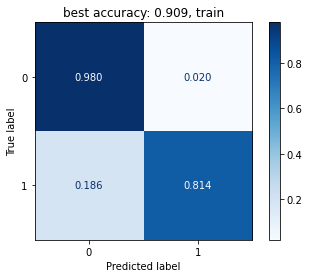

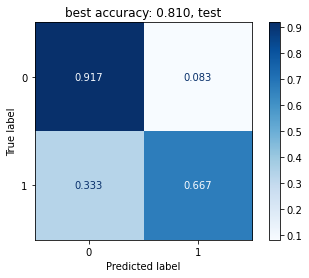

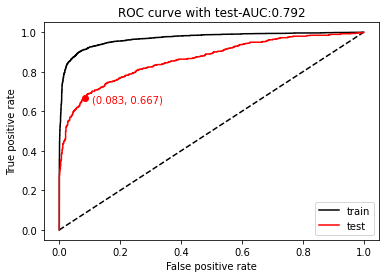

CPU times: user 1.07 s, sys: 8.02 ms, total: 1.08 s
Wall time: 1.09 s


In [70]:
# minor postprocessing: remove numbers and #,@, .... Special characters
df = my_df_text_mining(disaster_tweets.copy(), 'text')  
pipeMNB = make_pipeline(TfidfVectorizer(ngram_range=(1, 1)), MultinomialNB()) #### naive bayes 
%time fpr_1, tpr_1, auc_1 = my_fit_cm(df, pipeMNB, "text", "target")
pipe_name.append( 'clean lemma >> TFIDF(1,1), MNB' )
auc.append( auc_1 )
fpr.append( fpr_1 )
tpr.append( tpr_1 )

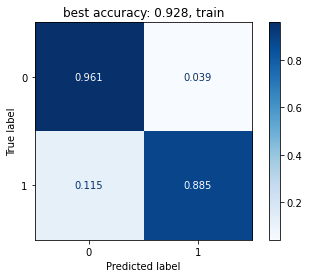

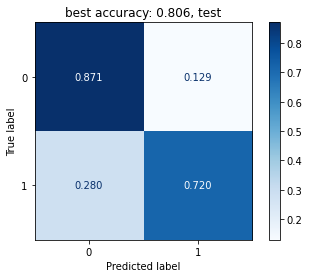

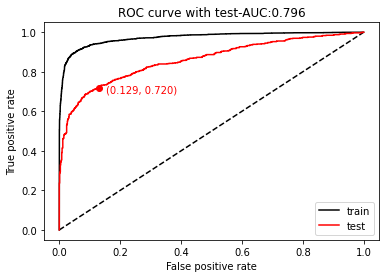

CPU times: user 1.01 s, sys: 11.1 ms, total: 1.02 s
Wall time: 1.02 s


In [71]:
# minor postprocessing: remove numbers and #,@, .... Special characters
df = my_df_text_mining(disaster_tweets.copy(), 'text')  
pipeMNB = make_pipeline(CountVectorizer(), MultinomialNB()) #### naive bayes 
%time fpr_2, tpr_2, auc_2 = my_fit_cm(df, pipeMNB, "text", "target")
pipe_name.append( 'clean lemma >> CV(1,1), MNB' )
auc.append( auc_2 )
fpr.append( fpr_2 )
tpr.append( tpr_2 )

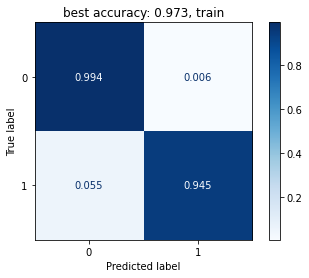

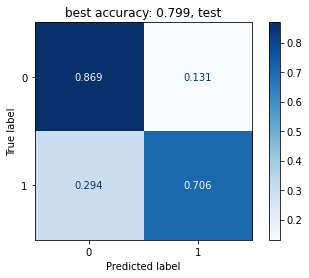

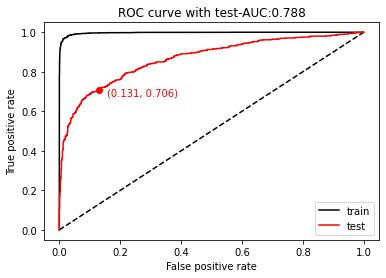

CPU times: user 1.63 s, sys: 442 ms, total: 2.07 s
Wall time: 1.61 s


In [72]:
# minor postprocessing: remove numbers and #,@, .... Special characters
df = my_df_text_mining(disaster_tweets.copy(), 'text')  
pipeMNB = make_pipeline(CountVectorizer(), LogisticRegression()) 
%time fpr_3, tpr_3, auc_3 = my_fit_cm(df, pipeMNB, "text", "target")
pipe_name.append( 'clean lemma >> CV(1,1), LogReg' )
auc.append( auc_3 )
fpr.append( fpr_3 )
tpr.append( tpr_3 )

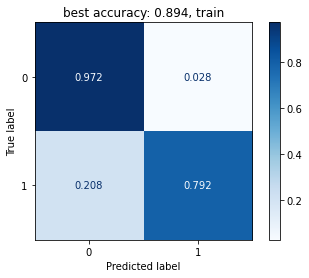

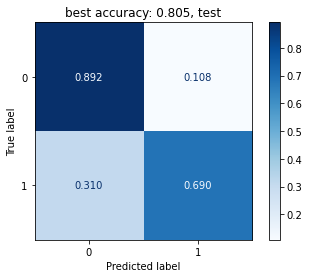

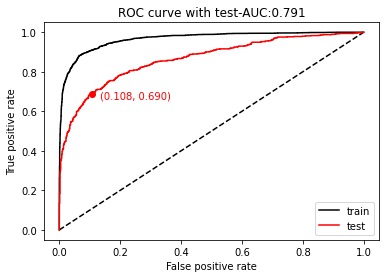

CPU times: user 1.32 s, sys: 244 ms, total: 1.57 s
Wall time: 1.29 s


In [73]:
# minor postprocessing: remove numbers and #,@, .... Special characters
df = my_df_text_mining(disaster_tweets.copy(), 'text')  
pipeMNB = make_pipeline(TfidfVectorizer(ngram_range=(1, 1)), LogisticRegression()) 
%time fpr_4, tpr_4, auc_4 = my_fit_cm(df, pipeMNB, "text", "target")
pipe_name.append( 'clean lemma >> TFIDF(1,1), LogReg' )
auc.append( auc_4 )
fpr.append( fpr_4 )
tpr.append( tpr_4 )

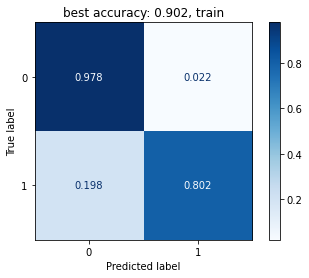

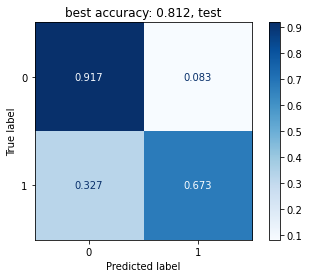

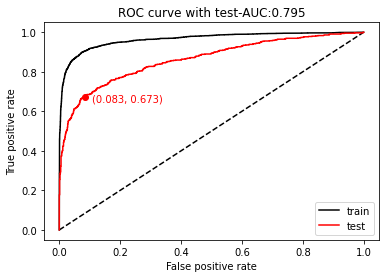

CPU times: user 1.27 s, sys: 17 ms, total: 1.29 s
Wall time: 1.31 s


In [74]:
#### stemmer

# minor postprocessing: remove numbers and #,@, .... Special characters
df = my_df_text_mining2(disaster_tweets.copy(), 'text')  
pipeMNB = make_pipeline(TfidfVectorizer(ngram_range=(1, 1)), MultinomialNB()) #### naive bayes 
%time fpr_5, tpr_5, auc_5 = my_fit_cm(df, pipeMNB, "text", "target")
pipe_name.append( 'cleaned, stemmer >> TFIDF(1,1), MNB' )
auc.append( auc_5 )
fpr.append( fpr_5 )
tpr.append( tpr_5 )

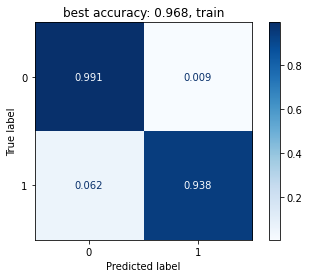

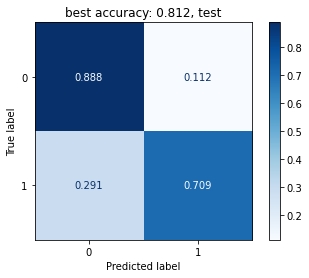

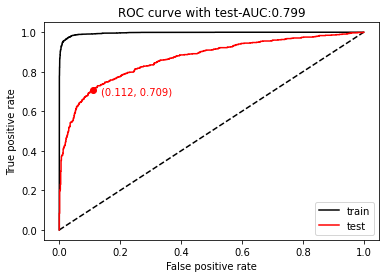

CPU times: user 1.59 s, sys: 410 ms, total: 2 s
Wall time: 1.51 s


In [75]:
#clean df
df = my_df_text_mining2(dtt_clean.copy(), 'text') 
pipeMNB = make_pipeline(CountVectorizer(), LogisticRegression()) 
%time fpr_5, tpr_5, auc_5 = my_fit_cm(df, pipeMNB, "text", "target")
pipe_name.append( 'cleaned  >> CountV, LogR' )
auc.append( auc_5 )
fpr.append( fpr_5 )
tpr.append( tpr_5 )

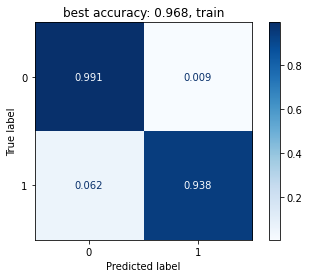

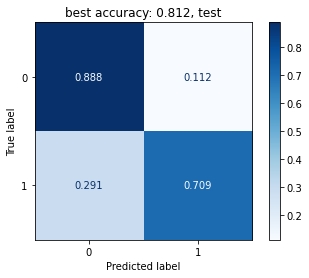

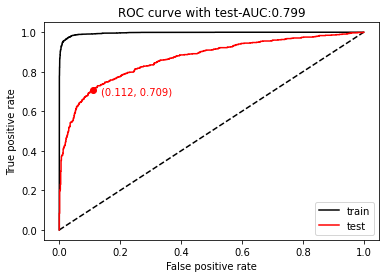

CPU times: user 1.56 s, sys: 423 ms, total: 1.98 s
Wall time: 1.49 s


In [76]:
#clean df_keys with targes mean
df = my_df_text_mining2(df_keys.copy(), 'text') 
pipeMNB = make_pipeline(CountVectorizer(), LogisticRegression()) 
%time fpr_5, tpr_5, auc_5 = my_fit_cm(df, pipeMNB, "text", "target")
pipe_name.append( 'cleaned + targes mean  >> CountV, LogR' )
auc.append( auc_5 )
fpr.append( fpr_5 )
tpr.append( tpr_5 )

# Evaluation extended Modeling (weitere Spalten)

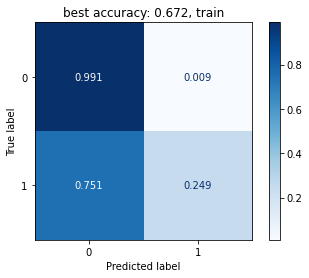

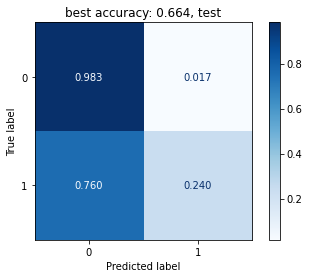

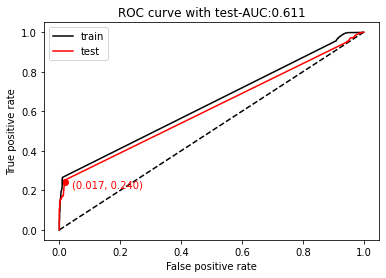

CPU times: user 693 ms, sys: 8.68 ms, total: 701 ms
Wall time: 719 ms


In [77]:
df = my_df_spacy_locgpe(disaster_tweets.copy(), 'text')

pipeMNB = make_pipeline(TfidfVectorizer(ngram_range=(1, 2)), MultinomialNB()) #### naive bayes 
%time fpr_loc0, tpr_loc0, aucloc_0 = my_fit_cm(df, pipeMNB, 'loc_gpe', "target")
pipe_name.append( 'NER  >> Tfidf, MNB' )
auc.append( aucloc_0 )
fpr.append( fpr_loc0 )
tpr.append( tpr_loc0 )
# poor result: acc= 0.664

In [78]:
# some counts
# ready to delete
df = disaster_tweets.copy()
df['_#_'] = df['text'].apply(lambda x: str(x).count('#') )
df['_@_'] = df['text'].apply(lambda x: str(x).count('@') )
df['_/_'] = df['text'].apply(lambda x: str(x).count('/') )
#df

# Final Model

In [79]:
# Performance

In [80]:
def plot_roc_auc(pipe_name_list, fpr_list, tpr_list, auc_list):
  fig = plt.figure(figsize=(10, 10), dpi=100)
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title(f"ROC curve with test-AUC")

  for pn, fpr, tpr, auc in zip(pipe_name_list, fpr_list, tpr_list, auc_list):
    plt.plot(fpr, tpr, label=pn+" auc:"+str(f"{auc:0.3f}"))
  
  plt.legend(fontsize=10) # using a size in points
  plt.legend(loc='best')
  plt.legend(loc='lower left', bbox_to_anchor=(1.1, 0))
  plt.show()

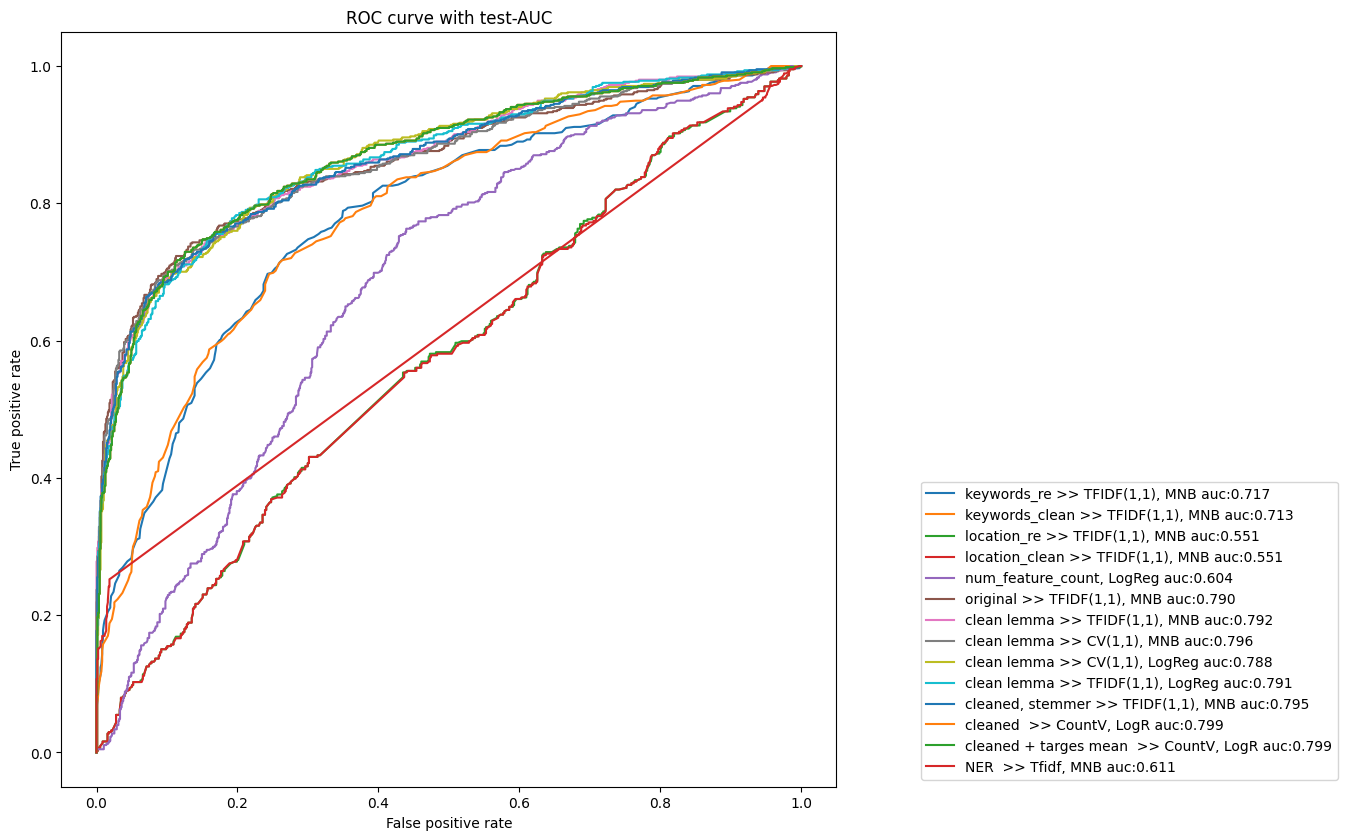

In [81]:
plot_roc_auc(pipe_name, fpr, tpr, auc)